[View in Colaboratory](https://colab.research.google.com/github/asonabend/Phenotype_prediction/blob/master/Phenot_pred_simulations.ipynb)

In [0]:

# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
import tensorflow as tf
import numpy as np
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt


In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2a. Get the file
downloaded = drive.CreateFile({'id':'1fupXX3KJWTbdI7MLPHKbDyEDKAXCzO7a'}) # replace the id with id of file you want to access
downloaded.GetContentFile('raprod2.ra.full.csv')  
#3a. Read file as panda dataframe
dat_pop = pd.read_csv('raprod2.ra.full.csv') 

#2b. Get the file
downloaded = drive.CreateFile({'id':'1Igod8k0utRAqgK4BeEuZqj31JCURQQ5K'}) 
downloaded.GetContentFile('cui2vec_RAsubset.csv')  
#3b. Read file as panda dataframe
cui_subset = pd.read_csv('cui2vec_RAsubset.csv') 

#2c. Get the file
downloaded = drive.CreateFile({'id':'1Z8YK2sVwKeA0OsZQV-sMNeFSkAI0zX02'}) 
downloaded.GetContentFile('C1858558.csv')  
#3c. Read file as panda dataframe
C1858558 = pd.read_csv('C1858558.csv') 


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Convert to matrix and remove unnamed column:
np_C0003873 = cui_subset.loc[cui_subset[list(cui_subset)[0]] == 'C0003873'].values
np_C0003873 = np.delete(np_C0003873,0,1)#.flatten()

np_cui_subset = cui_subset.loc[:, ~cui_subset.columns.str.contains('^Unnamed')].as_matrix()

# Select top 10 percent:
# Calculates cosine similarities:
np_cos_sim = ([np_C0003873.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C0003873))
np_cos_sim = np_cos_sim/sum(np_cos_sim)
close_CUIs = (abs(np_cos_sim) > np.percentile(abs(np_cos_sim),97.5)).flatten()
np_cui_subset = np_cui_subset[close_CUIs,:]

# Create tensorflow constants for RA CUI 
#tf_C1858558 = tf.constant(np_C1858558,name='RAcui', dtype=tf.float32)


# Calculates cosine similarities:
np_cos_sim = ([np_C0003873.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C0003873))
np_cos_sim = np_cos_sim/sum(np_cos_sim)


In [178]:
patients_No = 500
CUIs_No = len(np_cos_sim)
np.random.seed(116687)
# F and power law distribution mix to keep the count matrix similar to that of the RA real data
scaling = np.random.f(2, 10, patients_No)*100
sim_counts = np.array([np.round((np.random.power(.05, CUI_No)*scaling[p])) for p in range(patients_No)])
# Weights for each CUI
vec_weights = np.random.normal(0,10,size=CUIs_No)

raw_vals = 


array([ -6.31353193, -10.08878291,  -7.07265559,  -5.50799929,
         2.81785865, -18.57147932,   8.09311821,   0.6915968 ,
        -8.50196492,  -6.38800936,   4.81949218,  -0.36163567,
        -2.39281501,  -1.92904968,   3.55377347,  -8.97648407,
       -14.28924159,   2.32390327,   4.30949835,  -2.75556696,
       -16.33109015])

array([15, 21, 21, 21,  4, 23, 28,  7, 20, 24,  2, 17,  4, 11, 17, 21, 29,
       29,  3, 20, 28])

In [0]:
# Clear out old graph
tf.reset_default_graph()

# Create graph
sess = tf.Session()


In [0]:
# Convert to matrix and remove unnamed column:
np_C1858558 = C1858558.loc[:, ~C1858558.columns.str.contains('^Unnamed')].as_matrix()
np_cui_subset = cui_subset.loc[:, ~cui_subset.columns.str.contains('^Unnamed')].as_matrix()
# Create tensorflow constants for RA CUI and the CUI matrix

tf_C1858558 = tf.constant(np_C1858558,name='RAcui', dtype=tf.float32)
tf_cui_subset = tf.constant(np_cui_subset,name='CUIsubset', dtype=tf.float32)

In [6]:
np_C1858558.shape

(1, 500)

In [0]:
# Calculates cosine similarities:
np_cos_sim = [np_C1858558.dot(np_cui_subset[i,:])/(LA.norm(np_cui_subset[i,:])) for i in range(np_cui_subset.shape[0])]/LA.norm(np_C1858558)
# Create tensorflow constants the cosine similarities
tf_cos_sim = tf.constant(np_cos_sim,name='cos_sim', dtype=tf.float32)


In [0]:
# X matrix which contains X_ij, the centered count of CUI j in patient's i notes:
### First I filter the non-labeled rows then I filter the CUI's not mentioned in the notes
counts = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,list(cui_subset.iloc[:,0])]
### Now I center the counts and convert it to matrix
X = (counts-counts.mean()).as_matrix().transpose()
np_X_poly = np.array([[np.ones(X.shape[1]),X[cui,:],np.square(X[cui,:])] for cui in range(X.shape[0])])
### Now I convert it to a tensorflow constant:
tf_X_poly = tf.constant(np_X_poly,name='CUIcounts', dtype=tf.float32)#,shape=np_X_poly.shape
# Patients response::
y = dat_pop.loc[dat_pop['label'].isin(['Y','N'])].loc[:,'label'].eq('Y').mul(1).as_matrix()


In [0]:
###
# Model Parameters
###

# Declare batch size
batch_size = 40

# Matrix Dimensions:
CUIs_No, CUIs_dim = np_cui_subset.shape
seed = 116687
patients_No = counts.shape[0]
theta_dim = 3


In [0]:
# Cosine sim. weighted CUI-embedding matrix:
Vw = tf.multiply(tf_cui_subset,tf_cos_sim)
# Turn it into a 3D tensor for multiplications later:
Vw = tf.expand_dims(Vw, axis=0)
# Replicate the Weighted word-vec matrix for evey patient:
Vws = tf.tile(Vw,[patients_No,1,1])


In [0]:
# Initialize parameters 
### theta such that f_j(x_ij)=theta0_j+theta1_j*X_ij+theta2_j*(X_ij)^2:
theta = tf.Variable(tf.random_normal(shape=[CUIs_No,1,theta_dim]),name='theta')
### beta for regression:
#beta = tf.Variable(np.ones((CUIs_dim,1))*1.0,name='beta', dtype=tf.float32)
#beta0 = tf.Variable(np.ones((1,1))*1.0,name='beta0', dtype=tf.float32)
beta = tf.Variable(tf.random_normal(shape=[CUIs_dim,1]),name='beta')
beta0 = tf.Variable(tf.random_normal(shape=[1,1]),name='beta0')
# Initialize placeholders
z_data = tf.placeholder(shape=[None, CUIs_dim], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:
####
# Declare model operations
####
# Calculate f_j(x)=theta0j+theta1j*x_ij+theta2j*x_ij^2 where j is a CUI
f_x = tf.transpose(tf.matmul(theta,tf_X_poly)) # tensor dimensions: (patiens_No,1,CUI_No)
# Cosine sim. weighted CUI-embedding matrix:
# Patient's feature vectors:
tf_Z = tf.squeeze(tf.matmul(f_x,Vws))
model_output = tf.add(tf.matmul(z_data, beta), beta0)


In [0]:
###
# Loss Functions
###
### Loss functions to optimize over beta: ###

# Specify 'Ridge' or 'LASSO'
#regression_type = 'LASSO'
regression_type = 'Ridge'

# Select appropriate loss function based on regression type
if regression_type == 'LASSO':

  lasso_param = tf.constant(0.9)
  heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(beta, lasso_param)))))
  regularization_param = tf.multiply(heavyside_step, 99.)
  loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
# Declare the Ridge loss function
# Ridge loss = L2_loss + L2 norm of slope
  ridge_param = tf.constant(1.)
  ridge_loss = tf.reduce_mean(tf.square(beta))
  loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
  
### Loss functions to optimize over theta:###

tf.reduce_mean(tf.square(y_target - model_output))


In [0]:
###
# Optimizer
###

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(1e-12)
train_step = my_opt.minimize(loss)


In [0]:
###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)
np_Z = sess.run(tf_Z)
# Training loop
loss_vec = []
for i in range(15000):
    rand_index = np.random.choice(np_Z.shape[0], size=batch_size)
    rand_z = np_Z[rand_index,:]
    rand_y = np.array([y[rand_index]]).transpose()
    sess.run(train_step, feed_dict={z_data: rand_z, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={z_data: rand_z, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%1000==0:
      print('Step #' + str(i+1) + ' beta = ' + str(sess.run(beta)[0]) + ' beta0 = ' + str(sess.run(beta0)))
      print('Loss = ' + str(temp_loss))
      print('\n')


Step #1000 beta = [1.069153] beta0 = [[-0.8249107]]
Loss = [2.0655048e+08]


Step #2000 beta = [1.0058293] beta0 = [[-0.8249107]]
Loss = [2.4625774e+08]


Step #3000 beta = [0.96573514] beta0 = [[-0.8249107]]
Loss = [2.5148818e+08]


Step #4000 beta = [0.91954064] beta0 = [[-0.8249107]]
Loss = [75778370.]


Step #5000 beta = [0.8857983] beta0 = [[-0.8249107]]
Loss = [73210750.]


Step #6000 beta = [0.84855604] beta0 = [[-0.8249107]]
Loss = [1.8207262e+08]


Step #7000 beta = [0.8198247] beta0 = [[-0.8249107]]
Loss = [88825320.]


Step #8000 beta = [0.79367167] beta0 = [[-0.8249107]]
Loss = [1.8971909e+08]


Step #9000 beta = [0.76947993] beta0 = [[-0.8249107]]
Loss = [18283800.]


Step #10000 beta = [0.75353634] beta0 = [[-0.8249107]]
Loss = [51242772.]


Step #11000 beta = [0.730357] beta0 = [[-0.8249107]]
Loss = [1.5020757e+08]


Step #12000 beta = [0.7128799] beta0 = [[-0.8249107]]
Loss = [2.5352653e+08]


Step #13000 beta = [0.6930878] beta0 = [[-0.8249107]]
Loss = [15326118.]


St

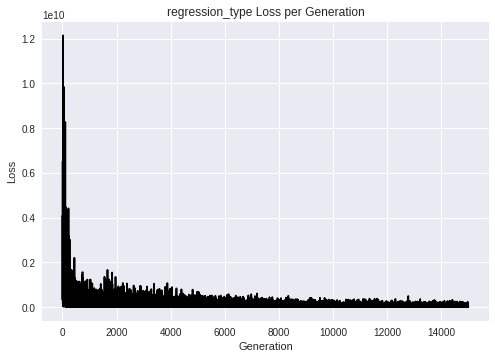

In [0]:
###
# Extract regression results
###

# Plot loss over time
plt.plot(loss_vec, 'k-')#[2000:len(loss_vec)]
plt.title('regression_type' + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [0]:
# Plot loss over time
plt.plot(b[0, 'k-')
plt.title('regression_type' + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [0]:
###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)
np_Z = sess.run(tf_Z)
print(sess.run(beta)[0])
print(sess.run(beta0))
# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(np_Z.shape[0], size=batch_size)
    rand_z = np_Z[rand_index,:]
    rand_y = np.array([y[rand_index]]).transpose()
    sess.run(train_step, feed_dict={z_data: rand_z, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={z_data: rand_z, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' beta = ' + str(sess.run(beta)[0]) + ' beta0 = ' + str(sess.run(beta0)))
        print('Loss = ' + str(temp_loss))
        print('\n')


[0.02085825]
[[1.8637991]]
Step #300 beta = [nan] beta0 = [[nan]]
Loss = [nan]


Step #600 beta = [nan] beta0 = [[nan]]
Loss = [nan]


Step #900 beta = [nan] beta0 = [[nan]]
Loss = [nan]


Step #1200 beta = [nan] beta0 = [[nan]]
Loss = [nan]


Step #1500 beta = [nan] beta0 = [[nan]]
Loss = [nan]




numpy.ndarray

In [0]:
###
# Load iris data
###

# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

###
# Model Parameters
###

# Declare batch size
batch_size = 50

# Initialize placeholders
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# make results reproducible
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# Create variables for linear regression
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# Declare model operations
model_output = tf.add(tf.matmul(x_data, A), b)

###
# Loss Functions
###

# Select appropriate loss function based on regression type

if regression_type == 'LASSO':
    # Declare Lasso loss function
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., tf.subtract(A, lasso_param)))))
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # Declare the Ridge loss function
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)


###
# Optimizer
###

# Declare optimizer
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

###
# Run regression
###

# Initialize variables
init = tf.global_variables_initializer()
sess.run(init)

# Training loop
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

###
# Extract regression results
###

# Get the optimal coefficients
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# Get best fit line
best_fit = []
for i in x_vals:
  best_fit.append(slope*i+y_intercept)



In [0]:
# Ridge regression:
### Declare model operations
reg_output = tf.add(tf.matmul(x_data, beta), beta0)
### Declare the Ridge loss function
# Ridge loss = L2_loss + L2 norm of slope
ridge_param = tf.constant(1.)
ridge_loss = tf.reduce_mean(tf.square(beta))


loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)), tf.multiply(ridge_param, ridge_loss)), 0)

NameError: ignored

In [0]:
x = tf.Variable(np.array([2,2]), name='x', dtype=tf.float32)
log_x = tf.log(x)
log_x_squared = tf.square(log_x)
